In [1]:
using Revise
using Pkg
Pkg.activate("/Users/jlazar/research/TAMBO-MC/tambo/")
using Tambo
using HDF5
using StaticArrays
using Random
using BenchmarkTools
units = Tambo.units

  Activating project at `~/research/TAMBO-MC/tambo`
┌ Info: Precompiling Tambo [d9a96183-4919-46da-8188-64ea4e10e0ed]
└ @ Base loading.jl:1423


(GeV = 1.0e9, TeV = 1.0e12, PeV = 1.0e15, eV = 1, m = 5.06773093741e6, km = 5.06773093741e9, cm = 50677.3093741, gr = 5.62e32, kg = 5.62e35, mwe = 2.1883118805254913e25, ρair0 = 5.289708721224576e15, ρrock0 = 1.1227136877701138e19, ρrock1 = 1.2522575748205115e19, ρrock2 = 1.4569369163601402e19)

In [2]:
(5000*units.ρair0) / (1000*units.ρrock0)

0.002355769230769231

In [39]:
@time begin
    ts = TAMBOSim()
    ts.seed = 6
    ts.n = 100000
    ts.θmin = π/2
    ts.θmax = π
    ts.r_injection = 0
    events = ts()
end;

 41.533917 seconds (315.81 M allocations: 21.384 GiB, 7.42% gc time)


In [40]:
d0 = Dict(
    :e=>"energy",
    :θ=>"zenith",
    :ϕ=>"azimuth",
    :ψ=>"psi",
    :impact_parameter=>"impact_parameter",
    :incoming_track=>"incoming_track",
    :outgoing_track=>"outgoing_track",
    :column_depth=>"column_depth",
    :interaction_vertex=>"interaction_vertex",
    :p_near=>"p_near",
    :tr=>"tr",
    :λ_int=>"affine_int",
#     :p_int=>"p_int"
)
dtrack = Dict(
    :ipoint=>Dict(
        1=>"ix",
        2=>"iy",
        3=>"iz"
    ),
    :fpoint=>Dict(
        1=>"fx",
        2=>"fy",
        3=>"fz"
    )
)
dpt = Dict(
    1=>"x",
    2=>"y",
    3=>"z"
)

# d1 = 
# fname = tempname()
@time begin
fname = "/Users/jlazar/research/TAMBO-MC/$(ts.n)_upgoing_noradius_injection_check.h5"
h5open(fname, "w") do fid
    for fn in fieldnames(Tambo.Event)
        saveable = [getfield(e, fn) for e in events]
        if typeof(saveable[1])==SVector{3, Float64}
            for x in 1:3
                dset_name = d0[fn] * "_" * dpt[x]
                fid[dset_name] = getindex.(saveable, x)./units[:m]
            end
        elseif typeof(saveable[1])==Tambo.Track{Float64}
            for fn1 in [:ipoint, :fpoint]
                for x in 1:3
                    dset_name = d0[fn]* "_" * dtrack[fn1][x]
#                     println(saveable)
                    fid[dset_name] = getindex.(getfield.(saveable, fn1), x)./units[:m]
                end
            end
        elseif d0[fn]=="energy"
            fid[d0[fn]] = [getfield(e, fn)/units[:GeV] for e in events]
        elseif d0[fn]=="impact_parameter"
            fid[d0[fn]] = [getfield(e, fn)/units[:m] for e in events]
        elseif d0[fn]=="column_depth"
            fid[d0[fn]] = [getfield(e, fn)/(units[:gr]/units[:cm]^2) for e in events]
        else
            fid[d0[fn]] = [getfield(e, fn) for e in events]
        end
    end
end
end

  0.819579 seconds (8.93 M allocations: 638.470 MiB, 16.93% gc time, 49.51% compilation time)


In [38]:
sum(1 .- Tambo.inside.(getfield.(events, :interaction_vertex), ts.geo.valley))/1e5

0.00262

In [227]:
b = []
for x in xx./m .+ 21431.935546875
    push!(b, [g.spl(x,y)[1] for y in yy./m .+ 18264.509765625])


LoadError: UndefVarError: xx not defined

In [228]:
c = []
for x in xx./m .+ 21431.935546875
    push!(c, [spl(x,y)[1] for y in yy./m .+ 18264.509765625])
#     println()
end



LoadError: UndefVarError: xx not defined

In [229]:
ts = Tambo.TAMBOSim()
ts.n = 1000
# ts.ϕmin = π/2
# ts.ϕmax = π/2
# ts.θmin = 0
# ts.θmax = 0
# ts.r_injection = 0
ts.l_endcap = 10km
Tambo.verify_ts!(ts)

LoadError: UndefVarError: km not defined

In [230]:
e = rand(ts.n, ts.pl)

1000-element Vector{Float64}:
 1.0761354711493112e15
 9.962590797312632e15
 1.4471488775113918e15
 1.0769755444489951e15
 3.475242796924743e15
 1.6935363295925442e15
 1.1789202979148568e15
 2.4918463966242125e15
 2.487161562487724e15
 1.307121631960099e15
 2.1576463665996015e15
 2.993857438282123e15
 1.686404159433723e15
 ⋮
 6.05839832878574e15
 1.2483001900498135e15
 1.9957152151638308e15
 5.656914791818878e15
 2.0037689178544652e15
 2.8467957269439245e15
 5.047558012965424e15
 1.3003450343251998e15
 1.5952579687821418e15
 1.7231600988711412e16
 1.3889415494623148e15
 1.101502006654585e15

In [231]:
range = Tambo.lepton_range.(e, Ref(ts.ν_pdg))
println("The range in mwe is")
println(range[1]/(100Units.gr/Units.cm^2))

LoadError: MethodError: no method matching lepton_range(::Float64, ::Int64)
[0mClosest candidates are:
[0m  lepton_range(::Float64, [91m::Bool[39m) at ~/research/TAMBO-MC/tambo/src/Tambo.jl:103

In [232]:
p_near_m = p_near./m
sct = scatter3d(getfield.(p_near_m, :x), getfield.(p_near_m, :y), getfield.(p_near_m, :z), alpha=0.1)
# plot(sct)

LoadError: UndefVarError: p_near not defined

In [233]:
p_int_m = p_int./m
xx = getfield.(p_int_m, :x)
yy = getfield.(p_int_m, :y)
zz = getfield.(p_int_m, :z)
xrange = LinRange(minimum(xx), maximum(xx), 51)
yrange = LinRange(-20000, 20000, 200)
plt = plot([], [])
for xlxh in zip(xrange[1:end-1], xrange[2:end])
# @gif for xlxh in zip(xrange[1:end-1], xrange[2:end])
    xl, xh = xlxh
    mask = xx.>=xl .&& xx.<=xh
#     plt = scatter(yy[mask], zz[mask], alpha=0.2)
    scatter!(plt, yy[mask], zz[mask], alpha=0.2)
    plot!(plt, yrange, ts.geo.(Ref(sum(xlxh)*m/2), yrange.*m)./m)
    plot!(plt, legend=false, xlim=(-20000, 20000), ylim=(-3e4, 3e3), xlabel="Y [m]", ylabel="Z [m]")
    string_xl = @sprintf("%5.0f",xl)
    string_xh = @sprintf("%5.0f",xh)
    string_xlxh = string_xl * " m<=x<" * string_xh*" m"
    println(string_xl * ", " * string_xh)
    annotate!(plt, -1.9e4, -2.75e4, text(string_xlxh, :left, 9, "sans_serif"))
#     display(plt)
    if xl==xrange[2]
        break
    end
end
display(plot)

LoadError: UndefVarError: p_int not defined

In [234]:
p_int_m = p_int./m
xx = getfield.(p_int_m, :x)
sct = scatter3d(getfield.(p_int_m, :x), getfield.(p_int_m, :y), getfield.(p_int_m, :z), alpha=0.1)
scatter!(sct, [0], [0], [0])
plot!(ylim=(-4000, 4000), zlim=(-4e3, 3e3))
scatter!(sct, camera=(90,0))

LoadError: UndefVarError: p_int not defined

In [235]:
function muon_range(emu)
    emu_gev = emu / GeV
    da = 0.212/1.2
    db = 0.251e-3/1.2
    1 / db * log(1 + emu_gev*da/db)
end

ee = 10 .^ LinRange(4, 12, 200) .* GeV
plt = plot(ee./GeV, Tambo.lepton_range.(ee, Ref(16))./mwe, label="τ")
plot!(ee./GeV, Tambo.lepton_range.(ee, Ref(14))./mwe, label="μ")
plot(plt, xaxis=:log, yaxis=:log, xlabel="E_{ν} [GeV]", ylabel="Range [mwe]")


LoadError: UndefVarError: GeV not defined

In [236]:
function muon_range(emu)
    emu_gev = emu / GeV
    da = 0.212/1.2
    db = 0.251e-3/1.2
    1 / db * log(1 + emu_gev*da/db)
end

ee = 10 .^ LinRange(4, 12, 200) .* GeV
plt = plot(ee./GeV, Tambo.lepton_range.(ee, Ref(16))./mwe, label="τ")
plot!(ee./GeV, Tambo.lepton_range.(ee, Ref(14))./mwe, label="μ")
plot(plt, xaxis=:log, yaxis=:log, xlabel="E_{ν} [GeV]", ylabel="Range [mwe]")


LoadError: UndefVarError: GeV not defined

In [237]:
a = h5open("/Users/jlazar/research/TAMBO-MC/100_injection_check.h5")

🗂️ HDF5.File: (read-only) /Users/jlazar/research/TAMBO-MC/100_injection_check.h5
├─ 🔢 affine_int
├─ 🔢 azimuth
├─ 🔢 column_depth
├─ 🔢 energy
├─ 🔢 impact_parameter
├─ 🔢 incoming_track_fx
├─ 🔢 incoming_track_fy
├─ 🔢 incoming_track_fz
├─ 🔢 incoming_track_ix
├─ 🔢 incoming_track_iy
├─ 🔢 incoming_track_iz
├─ 🔢 interaction_vertex_x
├─ 🔢 interaction_vertex_y
├─ 🔢 interaction_vertex_z
├─ 🔢 outgoing_track_fx
├─ 🔢 outgoing_track_fy
├─ 🔢 outgoing_track_fz
├─ 🔢 outgoing_track_ix
├─ 🔢 outgoing_track_iy
├─ 🔢 outgoing_track_iz
├─ 🔢 p_near_x
├─ 🔢 p_near_y
├─ 🔢 p_near_z
├─ 🔢 psi
├─ 🔢 tr_fx
├─ 🔢 tr_fy
├─ 🔢 tr_fz
├─ 🔢 tr_ix
├─ 🔢 tr_iy
├─ 🔢 tr_iz
└─ 🔢 zenith

In [238]:
maximum(sqrt.(sum([a["interaction_vertex_x"][].^2 .+ a["interaction_vertex_y"][].^2 .+ a["interaction_vertex_z"][].^2])))

37335.828782538825

In [239]:
b = a["interaction_vertex_z"][] .- ts.geo.valley.(a["interaction_vertex_x"][], a["interaction_vertex_y"][])

1000-element Vector{Float64}:
 -24946.965419470787
  -2700.365514959909
 -20913.61644770262
   1682.0249312514286
  -1890.3750570365137
   3754.910756606737
   2610.5025256726212
  -6681.58194398908
  -3253.841045313279
  -5021.780245452437
  -1956.0388479305798
 -12802.043039149745
    -44.54109708923261
      ⋮
  -8085.867994535328
  -3848.943593591779
  -1956.312719949736
  -3949.3740859856653
 -14630.652714685013
  -6874.3993019093705
  -9304.699319506326
  -2209.6567789484743
  -2200.475584663232
 -22474.472084442936
     -4.137302375761578
    459.8463603855985

In [240]:
b[b.>0]

167-element Vector{Float64}:
 1682.0249312514286
 3754.910756606737
 2610.5025256726212
  581.1726783877516
  149.91714193123318
  494.0874370062958
 2122.9234931723086
 4081.3697302998844
  902.2244103457651
 1197.0097607729847
   30.025796109773182
 1455.3069434154108
 4255.164857949222
    ⋮
 3625.2102745078646
 9601.160888788108
  636.5658876781101
   75.06558582934645
 5895.22041058598
 2044.7564306540887
 1127.3171871761378
  848.2418844421209
 2802.42303637984
   67.95215490269709
  698.4519997781335
  459.8463603855985

In [241]:
for i in 1:100
    e = events[i]
    ts.geo.valley(e.interaction_vertex.x, e.interaction_vertex.y)
    d = e.interaction_vertex.z - ts.geo.valley(e.interaction_vertex.x, e.interaction_vertex.y)
    if d < 0
        println((d, i))
    end
end

(-7.669132664641953e10, 1)
(-2.5916190716500465e10, 2)
(-1.1870340851016605e10, 3)
(-3.526354093980181e10, 4)
(-8.277511036565961e8, 5)
(-2.696646125116351e10, 6)
(-3.243681601727206e9, 7)
(-2.494197372689391e9, 8)
(-4.95158192957877e9, 9)
(-3.2861870915443142e10, 10)
(-8.115275333678435e9, 11)
(-2.6135090195835695e9, 12)
(-4.656046635513358e10, 13)
(-4.245407585563636e9, 14)
(-3.1822220683844414e10, 15)
(-1.9423092460901253e9, 16)
(-5.201639359798789e8, 17)
(-1.7316931121076584e10, 18)
(-1.8089851117988342e10, 19)
(-1.1693316632091187e10, 20)
(-2.4543702809957337e8, 21)
(-1.032354086590354e9, 22)
(-1.52489943942223e9, 23)
(-3.7570308209195215e8, 24)
(-1.9093178902323792e9, 25)
(-3.6562147702520065e10, 26)
(-2.279415356481614e10, 27)
(-2.3370487565114494e10, 28)
(-1.259016445069044e10, 29)
(-2.22817684375712e9, 30)
(-1.7048719313690102e10, 31)
(-5.141265777333853e9, 32)
(-9.278381832753935e9, 33)
(-1.1990597899484105e9, 34)
(-1.2711023509920268e9, 35)
(-3.65047166209095e8, 36)
(-5.2979

In [242]:
events[15].tr

Tambo.Track{Float64}([0.0, 0.0, 0.0], [1.1987352633755945e10, 1.4126704666922848e10, -2.533865468705e11], Tambo.Direction(3.0686038694316267, 0.8671390106416331, [0.047182600920265376, 0.0556031585106568, -0.9973375010166006]), 2.5406298932128735e11)

In [243]:
using Roots
function intersect1(t::Tambo.Track, z::Float64)
    root_func(λ) = t(λ).z - z
    zero = find_zero(root_func, (0, 1))
end

intersect1 (generic function with 1 method)

In [94]:
@btime intersect1(events[1].tr, -4.0e10)

  1.521 μs (16 allocations: 1.31 KiB)


0.2622681186682394

In [114]:
function intersect2(t::Tambo.Track, z::Float64)
    Δz = t.fpoint.z - t.ipoint.z
    root = (z-t.ipoint.z) / Δz
    if 0 < root < 1
        return root
    else
        return nothing
    end
end

intersect2 (generic function with 1 method)

In [115]:
@btime intersect2(events[1].tr, -4.e10)

  84.781 ns (3 allocations: 240 bytes)


0.2622681186682394

In [16]:
events[1].tr

Tambo.Track{Float64}([9.255806324403787e7, 4.7176905206479216e8, -1.7197607568532708e8], [-1.1205239493417807e11, -4.446358560539853e10, -1.837965249970332e11], Tambo.Direction(2.559661144289966, 3.522693666327759, [-0.5102051075128482, -0.204434054688721, -0.8354025769360135]), 2.198036659101811e11)

In [153]:
spl = Tambo.load_spline("/Users/jlazar/research/TAMBO-MC/resources/tambo_spline.jld2")
geo = Tambo.Geometry(spl, [12units.km, 21.4units.km], [2.9units.gr/units.cm^3, 3.37units.gr/units.cm^3]);

In [37]:
tr = Tambo.Track(SVector{3}([0,0,2000units.m]), Tambo.Direction(π, 0), geo.box)

Tambo.Track{Float64}([0.0, 0.0, 1.013546187482e10], [3.0734097732542295e-5, 0.0, -2.4082749131250366e11], Tambo.Direction(3.141592653589793, 0.0, [1.2246467991473532e-16, 0.0, -1.0]), 2.5096295318732367e11)

In [38]:
Tambo.getdensity(SVector{3}([0,0,-7.337182680691635e10]), geo)/units.gr*units.cm^3

2.6

In [109]:
zz/units.km

5000-element LinRange{Float64, Int64}:
 -47.5218,-47.5108,-47.4998,-47.4888,…,7.44523,7.45624,7.46724,7.47824

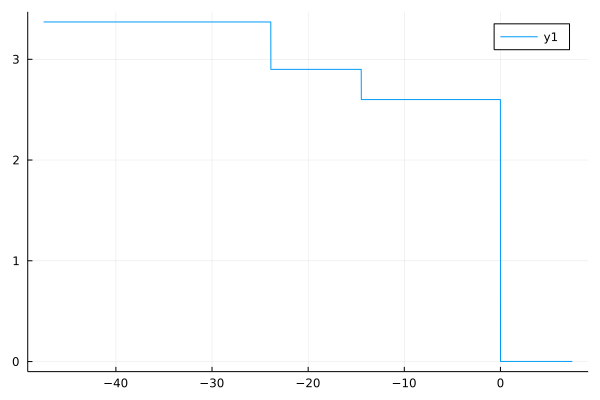

In [107]:
zz = LinRange(geo.box.c1.z, geo.box.c2.z, 5000)
pos = [SVector{3}([0.,0.,z]) for z in zz]
using Plots
plt = plot(zz/units.km, Tambo.getdensity.(pos, Ref(geo))/units.gr*units.cm^3)

In [40]:
ranges = Tambo.computeranges(tr, geo)

4-element Vector{Tuple{Float64, Float64, Float64}}:
 (0.0, 0.040386287083793965, 5.289708721224576e15)
 (0.040386287083793965, 0.2923611866814071, 1.1227136877701138e19)
 (0.33274747376520103, 0.18981554929383165, 1.2522575748205115e19)
 (0.5225630230590327, 0.4774369769409673, 1.4552096645328017e19)

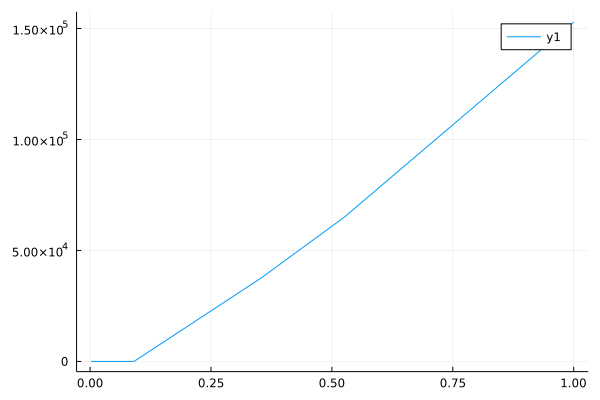

In [215]:
λλ = LinRange(0, 1, 500)
cdd = Tambo.columndepth.(Ref(tr), λλ, Ref(geo))
plot(λλ[2:end], cdd[2:end]/units.mwe)
# plot(λλ[2:end], cdd[2:end]/units.mwe, yaxis=:log)


In [ ]:
diff(λλ)

In [139]:
n = sqrt(sum(tr(λλ[2]).^2))
diff(cdd) / n / (units.gr / units.cm^3)

499-element Vector{Float64}:
  0.03191577023962874
  0.03191577023962874
  0.03191577023962874
  0.03191577023962874
  0.03191577023962874
  0.03191577023962874
  0.03191577023962874
  0.03191577023962874
  0.03191577023962868
  0.031915770239628785
  0.03191577023962868
  0.031915770239628785
  0.03191577023962869
  ⋮
 87.80093527147118
 87.80093527146443
 87.80093527147118
 87.80093527147118
 87.80093527146443
 87.80093527146443
 87.80093527147794
 87.80093527146443
 87.80093527146443
 87.80093527147118
 87.80093527147118
 87.80093527146443

In [167]:

Tambo.getdensity(SVector{3}([0, 0, (-21.4-2.5)units.km]), geo)/(units.gr/units.cm^3)

3.3700000000000006

In [158]:
tr = Tambo.Track(SVector{3}([0.0, 0.0, 2.533865468705e10]), Tambo.Direction(π, 0), geo.box)

Tambo.Track{Float64}([0.0, 0.0, 2.533865468705e10], [3.413399259291545e-5, 0.0, -2.533865468705e11], Tambo.Direction(3.141592653589793, 0.0, [1.2246467991473532e-16, 0.0, -1.0]), 2.7872520155755e11)

In [170]:
Tambo.totalcolumndepth(tr, geo)/units.ρrock1/units.km

52.73788961727209

In [161]:
geo.tambo_offset/units.km

3-element SVector{3, Float64} with indices SOneTo(3):
 22.110959780245448
 17.703873704953104
  2.478240402481784

In [ ]:
geo.